In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
PATH = '/data/laviniad/sermons-ir/references/'

n_gram_options = list(range(1, 6)) # 1 to 5
fsm_options = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
emb_options = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

best_option_indices = {'ngm': 2, 'fsm': 3, 'emb': 0}


for o in n_gram_options, fsm_options, emb_options:
    o = enumerate(o)

# sanity check
print(n_gram_options)


def load_data(met, idx):
    path = PATH + f'{met}/references_{met}_{idx}.csv'
    data = pd.read_csv(path)
    return data


# load data
met = 'emb'
embedding_data = load_data(met, best_option_indices[met])

met = 'fsm'
fsm_data = load_data(met, best_option_indices[met])

met = 'ngm'
ngram_data = load_data(met, best_option_indices[met])


[1, 2, 3, 4, 5]


In [3]:
# join on congress_idx

# join
data = pd.merge(embedding_data, ngram_data, on='text', suffixes=('_emb', '_ngm'))
# collapse cols if required...

# join again
fsm_data['label_fsm'] = fsm_data['label']
fsm_data['verse_fsm'] = fsm_data['verse']
fsm_data.drop(columns=['verse', 'label', 'congress_idx'], inplace=True)
data = pd.merge(data, fsm_data, on='text')

# collapse congress_idx columns and remove 'method_emb' and 'method_ngm' columns
data = data.drop(columns=['method_emb', 'method_ngm'])
data = data.rename(columns={'congress_idx_emb': 'congress_idx'})
data = data.drop(columns=['congress_idx_ngm', 'method'])

In [4]:
data['score_emb'] = data['label_emb']
data['score_ngm'] = data['label_ngm']
data['score_fsm'] = data['label_fsm']
data['label_emb'] = data['label_emb'].apply(lambda x: x > emb_options[best_option_indices['emb']])
data['label_ngm'] = data['label_ngm'].apply(lambda x: x > n_gram_options[best_option_indices['ngm']])
data['label_fsm'] = data['label_fsm'].apply(lambda x: x > fsm_options[best_option_indices['fsm']])

In [5]:
def plot_confusion_matrix(cm, title, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(title)
    plt.show()

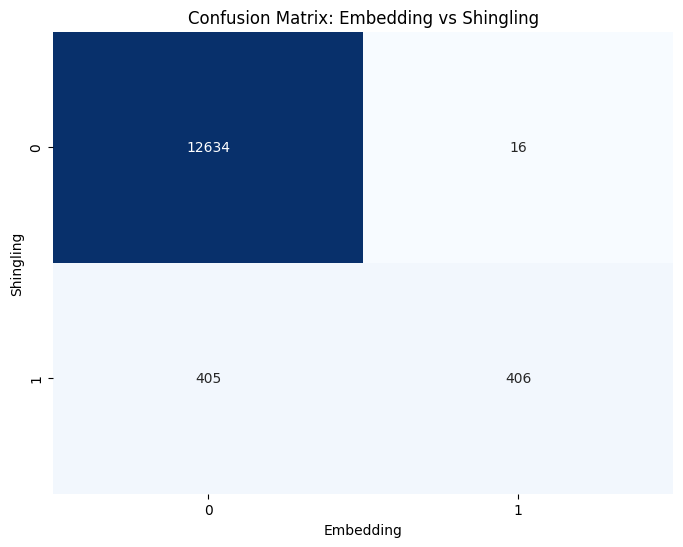

In [6]:
from sklearn.metrics import confusion_matrix

# calc confusion matrix
emb_fsm_confusion_matrix = confusion_matrix(data['label_emb'], data['label_ngm'])

# display
plot_confusion_matrix(emb_fsm_confusion_matrix, 'Confusion Matrix: Embedding vs Shingling', ['Embedding', 'Shingling'])

In [7]:
import sys
import os

print(sys.version)
print(sys.executable)
print(sys.path)

3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:48:41) [GCC 13.3.0]
/home/laviniad/miniconda3/envs/sermons/bin/python
['/home/laviniad/miniconda3/envs/sermons/lib/python312.zip', '/home/laviniad/miniconda3/envs/sermons/lib/python3.12', '/home/laviniad/miniconda3/envs/sermons/lib/python3.12/lib-dynload', '', '/home/laviniad/miniconda3/envs/sermons/lib/python3.12/site-packages']


In [8]:
sys.path.append("/home/laviniad/.local/lib/python3.12/site-packages")
sys.path.append("/home/laviniad/projects/religion_in_congress/src")


In [9]:
!pip install --user -e /home/laviniad/projects/religion_in_congress
!pip install --user -e /home/laviniad/projects/religion_in_congress/src

Obtaining file:///home/laviniad/projects/religion_in_congress
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for religion_in_congress (pyproject.toml) ... done
  Created wheel for religion_in_congress: filename=religion_in_congress-0.1.0-0.editable-py3-none-any.whl size=1488 sha256=fcd5a1d38203979654bd5cab6de34e7003d67e5e133d0ad92d1630053ca33a97
  Stored in directory: /tmp/pip-ephem-wheel-cache-_w5i23xy/wheels/2a/d3/cf/3a31f27a9baa624bc3dea1f610095a986443c06b7fe2737d02
Successfully built religion_in_congress
Obtaining file:///home/laviniad/projects/religion_in_congress/src
ERROR: file:///home/laviniad/projects/religion_in_congress/src does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [10]:
# actual eval data
def load_eval_data():
    TRUE_POSITIVE_PATH = '/home/laviniad/projects/religion_in_congress/src/references/validation/data/true_positive_examples.csv'
    TRUE_NEGATIVE_PATH = '/home/laviniad/projects/religion_in_congress/src/references/validation/data/true_negative_examples.csv'

    true_positive_df = pd.read_csv(TRUE_POSITIVE_PATH)
    true_negative_df = pd.read_csv(TRUE_NEGATIVE_PATH)
    true_negative_df.rename(columns={'speech_id': 'congress_idx', 'sentence': 'text', 'reference': 'verse', 'score': 'label'}, inplace=True)

    true_positive_df['label'] = [1 for i in range(len(true_positive_df.index))]
    true_negative_df['label'] = [0 for i in range(len(true_negative_df.index))]

    # concat
    cr_df = pd.concat([true_positive_df, true_negative_df])
    # remove 'tensor(' and ')' from congress_idx; convert to int
    cr_df['congress_idx'] = cr_df['congress_idx'].apply(lambda x: int(x[7:-1]) if (isinstance(x, str) and 'tensor' in x) else int(x))
    return true_positive_df, true_negative_df, cr_df


pos_df, neg_df, cr_df = load_eval_data()

In [11]:
def is_false_example(text):
    return text in neg_df['text'].values

true_negatives = data[data['text'].apply(is_false_example)]
true_positives = data[~data['text'].apply(is_false_example)]

def actual_verse(text):
    return cr_df[cr_df['text'] == text]['verse'].values[0]

true_positives['verse_true'] = true_positives['text'].apply(actual_verse)

/tmp/ipykernel_634713/2140210806.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_positives['verse_true'] = true_positives['text'].apply(actual_verse)


In [12]:
def agg_score(text, emb_thresh = 0.5, ngm_thresh = 3):
    data_row = data[data['text'] == text]
    emb_score = data_row['score_emb'].values[0]
    ngm_score = data_row['score_ngm'].values[0]
    return (emb_score > emb_thresh) or (ngm_score >= ngm_thresh)

cr_df['mock_label'] = cr_df['text'].apply(agg_score)

In [45]:
from sklearn.metrics import f1_score

f1_score(cr_df['label'], cr_df['mock_label'])

0.8941176470588235

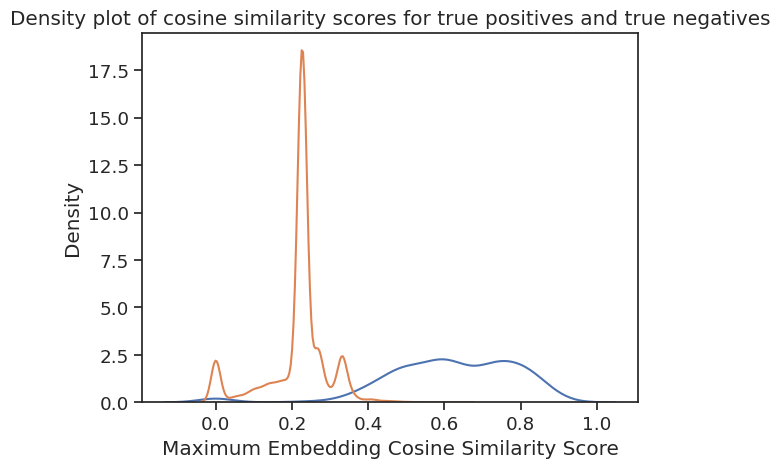

In [46]:
# make kde plots of true positives and true negatives' scores

sns.kdeplot(true_positives['score_emb'], label='True Positives')
sns.kdeplot(true_negatives['score_emb'], label='True Negatives')
plt.xlabel('Maximum Embedding Cosine Similarity Score')
plt.ylabel('Density')
plt.title('Density plot of cosine similarity scores for true positives and true negatives')
plt.show()

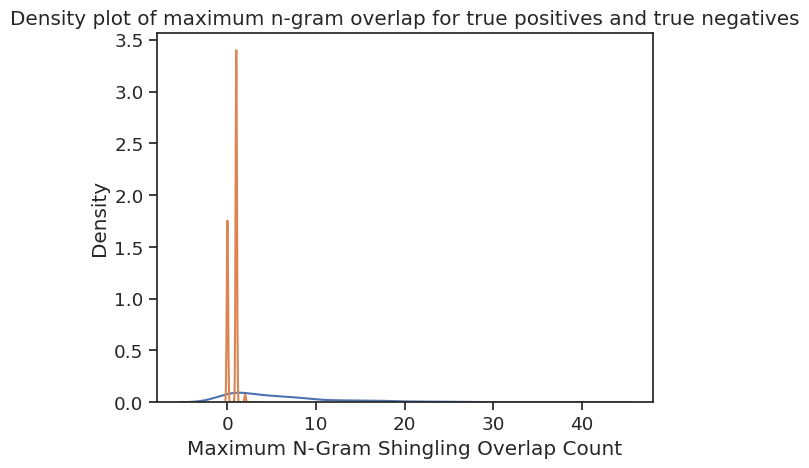

In [47]:
sns.kdeplot(true_positives['score_ngm'], label='True Positives')
sns.kdeplot(true_negatives['score_ngm'], label='True Negatives')
plt.xlabel('Maximum N-Gram Shingling Overlap Count')
plt.ylabel('Density')
plt.title('Density plot of maximum n-gram overlap for true positives and true negatives')
plt.show()

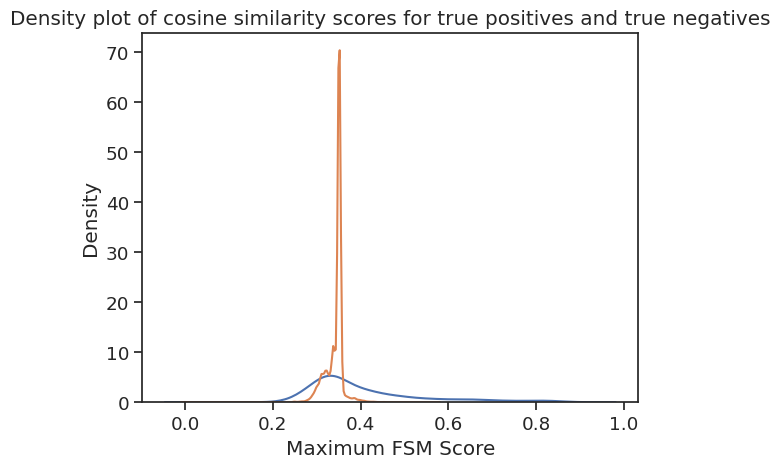

In [48]:
sns.kdeplot(true_positives['score_fsm'], label='True Positives')
sns.kdeplot(true_negatives['score_fsm'], label='True Negatives')
plt.xlabel('Maximum FSM Score')
plt.ylabel('Density')
plt.title('Density plot of FSM scores for true positives and true negatives')
plt.show()

In [49]:
true_negatives[true_negatives['score_ngm'] > 3]['verse_ngm'].value_counts()

verse_ngm
joshua 24:15    5
luke 24:49      1
Name: count, dtype: int64

In [50]:
true_negatives[true_negatives['score_emb'] > 0.4]['verse_emb'].value_counts()

verse_emb
philippians 3:14       8
ephesians 4:3          6
john 1:4               6
psalm 127:3            5
2 corinthians 3:17     4
                      ..
1 corinthians 13:13    1
ephesians 5:20         1
ephesians 6:18         1
proverbs 22:6          1
ephesians 2:19         1
Name: count, Length: 68, dtype: int64

In [22]:
# for true negatives, what verse does the embedding method usually predict?

true_negatives[(true_negatives['score_emb'] < 0.25) & (true_negatives['score_emb'] > 0.2)]['verse_emb'].value_counts()

verse_emb
romans 3:10            6859
ephesians 4:3            48
colossians 4:2           38
2 corinthians 3:17       22
2 timothy 4:7            19
                       ... 
acts 1:4                  1
1 john 4:16               1
hebrews 13:4              1
job 1:1                   1
1 corinthians 13:12       1
Name: count, Length: 250, dtype: int64

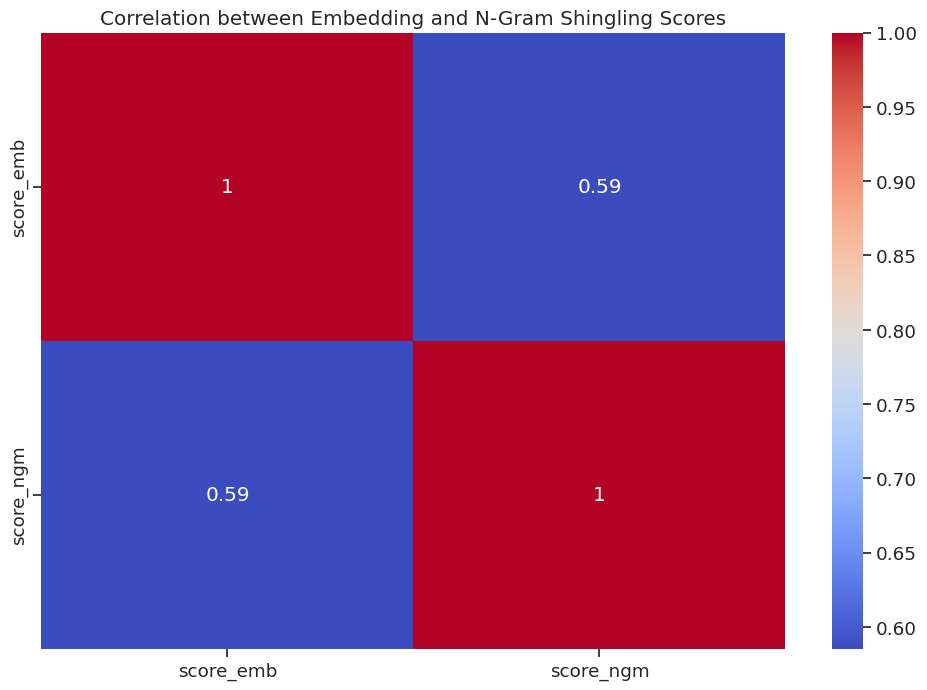

In [24]:
# heatmap of scores for all instances -- emb and ngm
plt.figure(figsize=(12, 8))
sns.heatmap(data[['score_emb', 'score_ngm']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Embedding and N-Gram Shingling Scores')
plt.show()

In [13]:
import pandas as pd

NGRAM_PATH = "/data/laviniad/sermons-ir/references/references_ngram_shingling_min_count_overlap_SAMPLE.csv"
EMBEDDING_PATH = "/data/laviniad/sermons-ir/references/emb/references_embedding_similarity_SAMPLE.csv"

ngram_data = pd.read_csv(NGRAM_PATH)
embedding_data = pd.read_csv(EMBEDDING_PATH)
print(ngram_data.head())
print(embedding_data.head())

   congress_idx                                               text  \
0       2383209  After the indictment was issued, I heard throu...   
1        707556                         However, this is not true.   
2       2395608  How can we exploit the taxpayer by adding to t...   
3        738434  As the gentleman mentioned he and our colleagu...   
4        856055  The goal is to give people at home the power t...   

               verse  label                             method  \
0  2 chronicles 7:14    1.0  ngram_shingling_min_count_overlap   
1      zechariah 4:6    1.0  ngram_shingling_min_count_overlap   
2               none    0.0  ngram_shingling_min_count_overlap   
3               none    0.0  ngram_shingling_min_count_overlap   
4       isaiah 29:13    1.0  ngram_shingling_min_count_overlap   

   positive_match_with_hyperparam  
0                           False  
1                           False  
2                           False  
3                           False  
4 

In [14]:
# join on congress_idx and text
data = pd.merge(ngram_data, embedding_data, on=['congress_idx', 'text'], suffixes=('_ngm', '_emb'))

In [15]:
# stratify label_ngm and label_emb into deciles
# Get the minimum and maximum values for each column
ngm_min = data['label_ngm'].min()
ngm_max = data['label_ngm'].max()

emb_min = data['label_emb'].min()
emb_max = data['label_emb'].max()

# Create bins based on the range
ngm_bins = np.linspace(ngm_min, ngm_max, 11)
emb_bins = np.linspace(emb_min, emb_max, 11)

# Cut the data into bins
data['label_ngm_perc'] = pd.cut(data['label_ngm'], bins=ngm_bins, labels=False, include_lowest=True)
data['label_emb_perc'] = pd.cut(data['label_emb'], bins=emb_bins, labels=False, include_lowest=True)


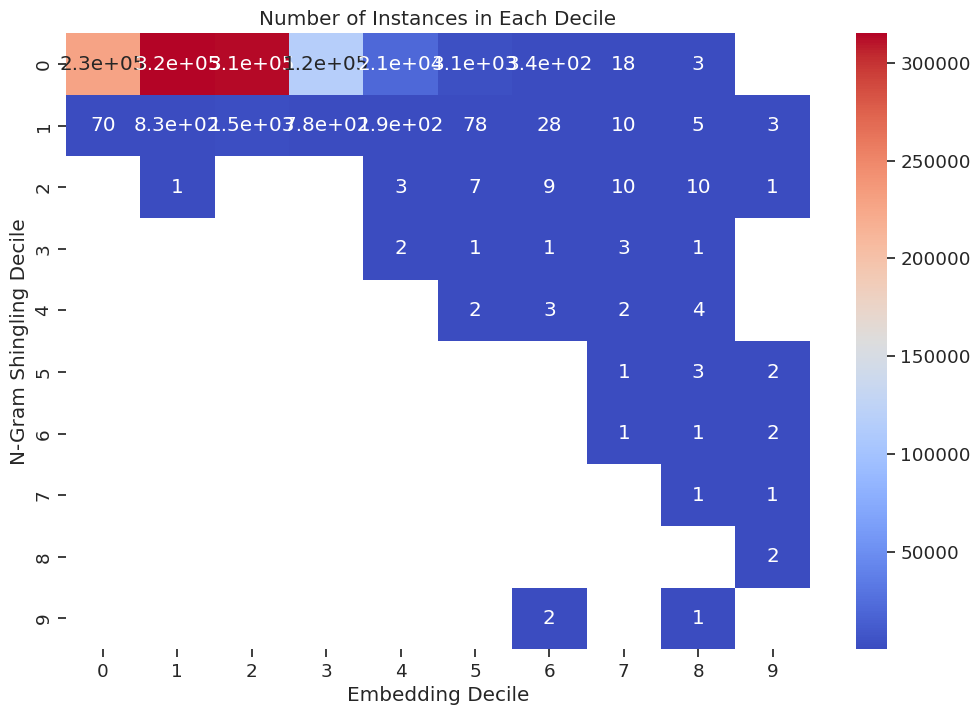

In [54]:
# plot heatmap of how many instances are in each decile
plt.figure(figsize=(12, 8))
sns.heatmap(data.groupby(['label_ngm_perc', 'label_emb_perc']).size().unstack(), annot=True, cmap='coolwarm')
plt.xlabel('Embedding Decile')
plt.ylabel('N-Gram Shingling Decile')
plt.title('Number of Instances in Each Decile')
plt.show()

In [68]:
import re
# Ensure the module is installed or adjust the import path
def reduced_verse_extractor(v):
    # just processes citation
    vsplit = v.split()
    cv = vsplit[-1]
    book = ' '.join(vsplit[:-1])
    chapter, verse = cv.split(':')
    #print(book, chapter, verse)
    
    return str(book), str(chapter), str(verse), str(v)

def comp_bible_helper(INPUT_PATH='/home/laviniad/projects/religion_in_congress/data/bibles/bibles.txt'):
    df = pd.read_csv(INPUT_PATH, sep='\t', encoding='latin-1')
    assert('Verse' in df.columns) # just a check
    #df[['book', 'chapter', 'verse', 'citation']] = df['Verse'].apply(lambda x: reduced_verse_extractor(x), result_type='expand')
    df[['book', 'chapter', 'verse', 'citation']] = df['Verse'].apply(lambda x: pd.Series(reduced_verse_extractor(x)))
    
    return df

OPTIONS = ['King James Bible','American Standard Version', 'Douay-Rheims Bible', 'Darby Bible Translation', 
               'English Revised Version', 'Webster Bible Translation', 'World English Bible', 
               'Young\'s Literal Translation', 'American King James Version']
    # if version is "ALL", load all versions and return in verse_df
print("Loading verses...")
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    if isinstance(text, str):
        return TAG_RE.sub('', text)
    return text

bible_df = comp_bible_helper()
pop_verses = pd.read_csv('/home/laviniad/projects/religion_in_congress/data/most_popular_verses.csv')
n = 1000 # VERY generous
pop_citations = list(pop_verses['verse'].iloc[1:n+2])

# remove tags (?)
for v in OPTIONS:
    bible_df[v] = bible_df[v].apply(remove_tags) # KJV in this df has italics etc
bible_df['Verse'] = bible_df['Verse'].apply(lambda x: x.lower())
limited_bible_df = bible_df[bible_df['Verse'].apply(lambda x: x in pop_citations)]

print("Creating dict of sets of verses for each version")
limited_verses = {r['Verse']: {v: r[v] for v in OPTIONS} for idx, r in limited_bible_df.iterrows()}

Loading verses...
Creating dict of sets of verses for each version


In [70]:
kjv_to_citation = {v['King James Bible']: k for k, v in limited_verses.items()} # this is the KJV verse to citation mapping

In [57]:
# get stratified examples for 'label_ngm' and 'label_emb'
# split by 'label_ngm_perc', 'label_emb_perc'
# get N for each decile (if possible)
# if not possible, get all

N = 25
special_example_set_ngm = []
special_example_set_emb = []

# note that these are not deciles per se, but rather the bins created by taking (max - min) / 10
for i in range(10):
    ngm_decile = data[data['label_ngm_perc'] == i]
    emb_decile = data[data['label_emb_perc'] == i]
    ngm_sample_int = min(N, len(ngm_decile))
    emb_sample_int = min(N, len(emb_decile))
    ngm_sample = ngm_decile.sample(n=ngm_sample_int, replace=False)
    emb_sample = emb_decile.sample(n=emb_sample_int, replace=False)
    ngm_sample['stratum'] = i
    emb_sample['stratum'] = i
    special_example_set_ngm.append(ngm_sample)
    special_example_set_emb.append(emb_sample)

# transform into dfs
special_example_set_ngm = pd.concat(special_example_set_ngm)
special_example_set_emb = pd.concat(special_example_set_emb)


In [49]:
# get the verse texts for each example
def get_verse_text(row, version, type='ngm'):
    verse = row['verse_' + type]
    if verse in limited_verses:
        return limited_verses[verse][version]
    else:
        return 'no_verse_met_threshold(ngm)'

In [59]:
# for each example in special_example_set_ngm, get the verse texts for every version

for v in OPTIONS:
    special_example_set_ngm[v] = special_example_set_ngm.apply(lambda x: get_verse_text(x, v, type='ngm'), axis=1)
    special_example_set_emb[v] = special_example_set_emb.apply(lambda x: get_verse_text(x, v, type='emb'), axis=1)

In [141]:
special_example_set_emb.columns

Index(['congress_idx', 'text', 'verse_ngm', 'label_ngm', 'method_ngm',
       'positive_match_with_hyperparam_ngm', 'verse_emb', 'label_emb',
       'method_emb', 'positive_match_with_hyperparam_emb', 'label_ngm_perc',
       'label_emb_perc', 'stratum', 'King James Bible',
       'American Standard Version', 'Douay-Rheims Bible',
       'Darby Bible Translation', 'English Revised Version',
       'Webster Bible Translation', 'World English Bible',
       'Young's Literal Translation', 'American King James Version'],
      dtype='object')

In [142]:
# make annotation version

# identify number of shared rows in special_example_set_ngm and special_example_set_emb
shared_rows = special_example_set_ngm.merge(special_example_set_emb, on='text')

In [143]:
# concatenate the two dfs, then drop duplicates
special_example_set = pd.concat([special_example_set_ngm, special_example_set_emb])
special_example_set = special_example_set.drop_duplicates(subset='text')

In [145]:
special_example_set.to_csv('/home/laviniad/projects/religion_in_congress/data/special_example_set_with_labels.csv', index=False)

In [18]:
special_example_set = pd.read_csv('/home/laviniad/projects/religion_in_congress/data/special_example_set_with_labels.csv')

In [19]:
len(special_example_set)

317

In [64]:
# drop all columns except 'text', 'congress_idx', bible versions
DUMP = False

if DUMP:
       scoring_cols = ['verse_ngm', 'label_ngm', 'method_ngm',
              'positive_match_with_hyperparam_ngm', 'verse_emb', 'label_emb',
              'method_emb', 'positive_match_with_hyperparam_emb', 'label_ngm_perc',
              'label_emb_perc', 'stratum']
       special_example_set = special_example_set.drop(columns=scoring_cols)
       # if the value in 'King James Bible' is 'no_verse_met_threshold(ngm)', drop row
       special_example_set = special_example_set[special_example_set['King James Bible'] != 'no_verse_met_threshold(ngm)']
       special_example_set.to_csv('/home/laviniad/projects/religion_in_congress/data/special_example_set.csv', index=False)

In [17]:
special_example_set = pd.read_csv('/home/laviniad/projects/religion_in_congress/data/special_example_set.csv')
# add scores from data
special_example_set = pd.merge(special_example_set, data[['text', 'label_emb', 'label_ngm', 'label_emb_perc']], on='text')

KeyError: "['label_emb_perc'] not in index"

In [16]:
dallas_annotations = pd.read_csv('/data/laviniad/bib_dallas_2-0.csv')
lavinia_annotations = pd.read_csv('/data/laviniad/bib_lavinia_1-0.csv')

In [17]:
# drop rows in lavinia_annotations and dallas_annotations where 'Label' is null
dallas_annotations = dallas_annotations.dropna(subset=['Label'])
lavinia_annotations = lavinia_annotations.dropna(subset=['Label'])

In [18]:
# merge dallas and lavinia dfs on 'text' and change 'Label' to 1 or 0 for 'Match' and not match
dallas_annotations['Match'] = dallas_annotations['Label'].apply(lambda x: int(x == 'Match'))
lavinia_annotations['Match'] = lavinia_annotations['Label'].apply(lambda x: int(x == 'Match'))


In [19]:
# merge on 'text'
annotation_df = pd.merge(dallas_annotations, lavinia_annotations, on='text', suffixes=('_dallas', '_lavinia'))

In [20]:
len(annotation_df)

150

In [21]:
# cohen's kappa
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(annotation_df['Match_dallas'], annotation_df['Match_lavinia'])

np.float64(0.9828178694158075)

In [22]:
# print rows with disagreement
disagreement = annotation_df[annotation_df['Match_dallas'] != annotation_df['Match_lavinia']]

In [23]:
print(str(disagreement['text'].iloc[0]))

So, let us break through those inhibitions to talk together, study together, and pray together, remembering the call in Chronicles to give thanks to God, to declare his name and to make his acts known among the peoples, to sing to him, and speak of all his wonders.


In [24]:
def recover_label(text, suffix):
    label_ent = data[data['text'] == text]['label_' + suffix]
    if len(label_ent) > 0:
        return label_ent.values[0]
    
    print(text)
    return None

In [25]:
# get embedding scores from special_example_set
annotation_df['label_emb'] = annotation_df['text'].apply(lambda x: recover_label(x, 'emb'))
annotation_df['label_ngm'] = annotation_df['text'].apply(lambda x: recover_label(x, 'ngm'))
annotation_df['label_emb_perc'] = annotation_df['text'].apply(lambda x: recover_label(x, 'emb_perc'))

In [26]:
annotation_df['label_emb_bin'] = annotation_df['label_emb'].apply(lambda x: int(x > 0.75))

In [27]:
# accuracy of model wrt dallas and lavinia
from sklearn.metrics import accuracy_score, f1_score
# model scores are in 'label_emb'
for threshold in [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]:
    annotation_df['label_emb_bin'] = annotation_df['label_emb'].apply(lambda x: int(x > threshold))
    print("Threshold: " + str(threshold))
    print(accuracy_score(annotation_df['Match_dallas'], annotation_df['label_emb_bin']))
    print(f1_score(annotation_df['Match_lavinia'], annotation_df['label_emb_bin']))

Threshold: 0.4
0.6933333333333334
0.64
Threshold: 0.45
0.76
0.6956521739130435
Threshold: 0.5
0.7933333333333333
0.7222222222222222
Threshold: 0.55
0.8266666666666667
0.7368421052631579
Threshold: 0.6
0.86
0.7777777777777778
Threshold: 0.65
0.9
0.8292682926829268
Threshold: 0.7
0.8866666666666667
0.7777777777777778
Threshold: 0.75
0.8866666666666667
0.7096774193548387
Threshold: 0.8
0.86
0.6206896551724138


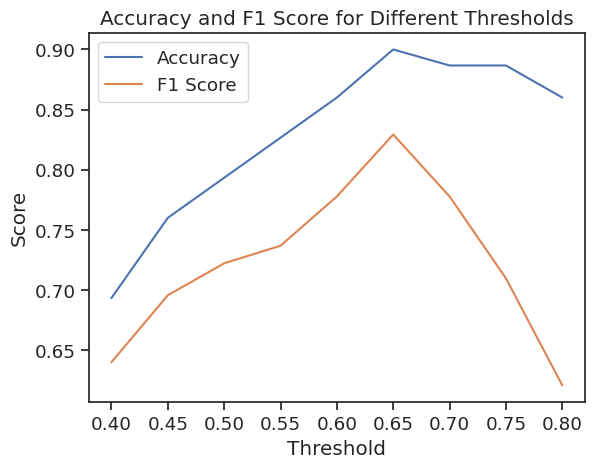

In [65]:
# plot accuracy and f1 score for each threshold

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
accuracy_scores = []
f1_scores = []
# also print out bin-level accuracies
for threshold in thresholds:
    annotation_df['label_emb_bin'] = annotation_df['label_emb'].apply(lambda x: int(x > threshold))
    accuracy_scores.append(accuracy_score(annotation_df['Match_dallas'], annotation_df['label_emb_bin']))
    f1_scores.append(f1_score(annotation_df['Match_lavinia'], annotation_df['label_emb_bin']))

plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score by Cosine Similarity Threshold')
plt.legend()
plt.show()

In [126]:
annotation_df.columns

Index(['congress_idx_dallas', 'original row', 'Round', 'rand', 'text',
       'Label_dallas', 'Notes_dallas', 'King James Bible_dallas',
       'American Standard Version_dallas', 'Douay-Rheims Bible_dallas',
       'Darby Bible Translation_dallas', 'English Revised Version_dallas',
       'Webster Bible Translation_dallas', 'World English Bible_dallas',
       'Young's Literal Translation_dallas',
       'American King James Version_dallas', '0_dallas', 'Match_dallas',
       'congress_idx_lavinia', 'Label_lavinia', 'Notes_lavinia',
       'King James Bible_lavinia', 'American Standard Version_lavinia',
       'Douay-Rheims Bible_lavinia', 'Darby Bible Translation_lavinia',
       'English Revised Version_lavinia', 'Webster Bible Translation_lavinia',
       'World English Bible_lavinia', 'Young's Literal Translation_lavinia',
       'American King James Version_lavinia', '0_lavinia', 'Match_lavinia',
       'label_emb', 'label_ngm', 'label_emb_perc', 'label_emb_bin'],
      dtype='ob

In [28]:
# heatmap of accuracy and f1 score for each ngm and emb threshold

from sklearn.metrics import accuracy_score, f1_score

def get_weighted_and_static_f1s_and_accs(gold_labels, thresh_label, stratum_weights):
    # get normal
    accuracy_score = accuracy_score(gold_labels, thresh_label)
    f1_score = f1_score(gold_labels, thresh_label)

    # get weighted
    weighted_accuracy_score = np.average(gold_labels == thresh_label, weights=gold_labels)
    weighted_f1_score = f1_score(gold_labels, thresh_label, average='weighted')

    return accuracy_score, f1_score, weighted_accuracy_score, weighted_f1_score


# first, create OR and AND columns for each threshold combo
emb_thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
ngm_thresholds = [1, 2, 3, 4, 5, 6, 7]

accuracy_scores_or = []
f1_scores_or = []
accuracy_scores_and = []
f1_scores_and = []

weighted_f1_scores_or = []
weighted_f1_scores_and = []
weighted_accuracy_scores_or = []
weighted_accuracy_scores_and = []

# create a df with all possible threshold combos
threshold_combos = []
for e in emb_thresholds:
    for n in ngm_thresholds:
        threshold_combos.append((e, n))

# get proportion of each stratum
annotation_df['stratum'] = annotation_df['label_emb_perc']
stratum_weights = annotation_df['stratum'].value_counts(normalize=True)
annotation_df['weight'] = annotation_df['stratum'].apply(lambda x: stratum_weights[x])

# create accuracy and f1 score columns for each threshold combo

for combo in threshold_combos:
    emb_thresh, ngm_thresh = combo
    annotation_df['label_emb_bin'] = annotation_df['label_emb'].apply(lambda x: int(x > emb_thresh))
    annotation_df['label_ngm_bin'] = annotation_df['label_ngm'].apply(lambda x: int(x >= ngm_thresh))
    annotation_df['label_emb_ngm_or'] = annotation_df['label_emb_bin'] | annotation_df['label_ngm_bin']
    annotation_df['label_emb_ngm_and'] = annotation_df['label_emb_bin'] & annotation_df['label_ngm_bin']

    accuracy_scores_or.append(accuracy_score(annotation_df['Match_dallas'], annotation_df['label_emb_ngm_or']))
    f1_scores_or.append(f1_score(annotation_df['Match_lavinia'], annotation_df['label_emb_ngm_or']))
    accuracy_scores_and.append(accuracy_score(annotation_df['Match_dallas'], annotation_df['label_emb_ngm_and']))
    f1_scores_and.append(f1_score(annotation_df['Match_lavinia'], annotation_df['label_emb_ngm_and']))

    # weighted f1 score
    weighted_f1_scores_or.append(f1_score(annotation_df['Match_lavinia'], annotation_df['label_emb_ngm_or'], average='weighted'))
    weighted_f1_scores_and.append(f1_score(annotation_df['Match_lavinia'], annotation_df['label_emb_ngm_and'], average='weighted'))

    # weighted accuracy
    weighted_accuracy_scores_or.append(accuracy_score(annotation_df['Match_dallas'], annotation_df['label_emb_ngm_or']))
    weighted_accuracy_scores_and.append(accuracy_score(annotation_df['Match_dallas'], annotation_df['label_emb_ngm_and']))


In [146]:
annotation_df.to_csv('/home/laviniad/projects/religion_in_congress/data/dallas_lavinia_combined_annotations.csv')

In [47]:
annotation_df = pd.read_csv('/home/laviniad/projects/religion_in_congress/data/dallas_lavinia_combined_annotations.csv')

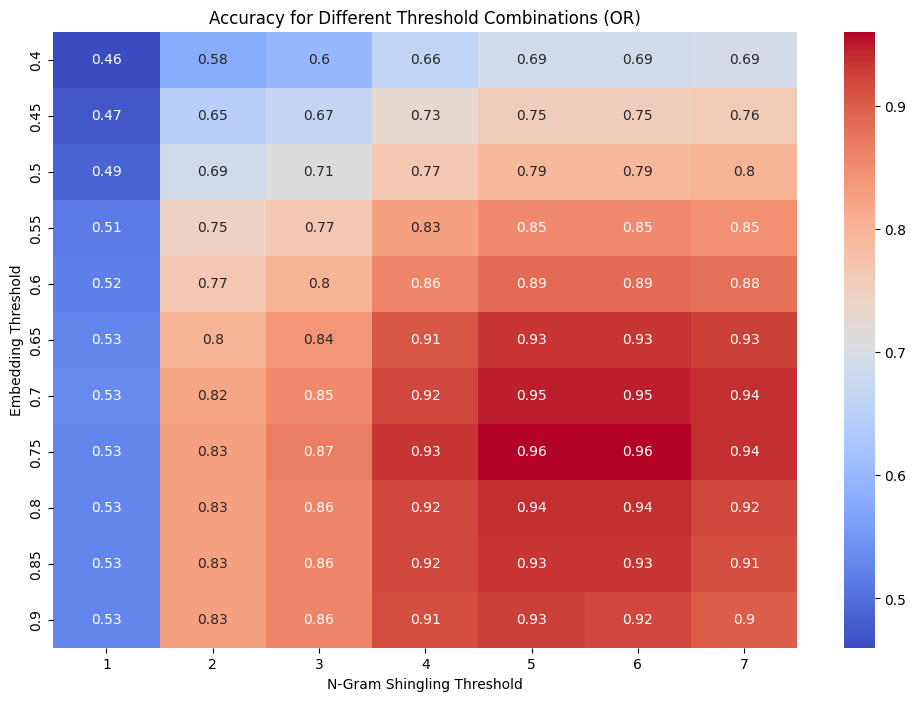

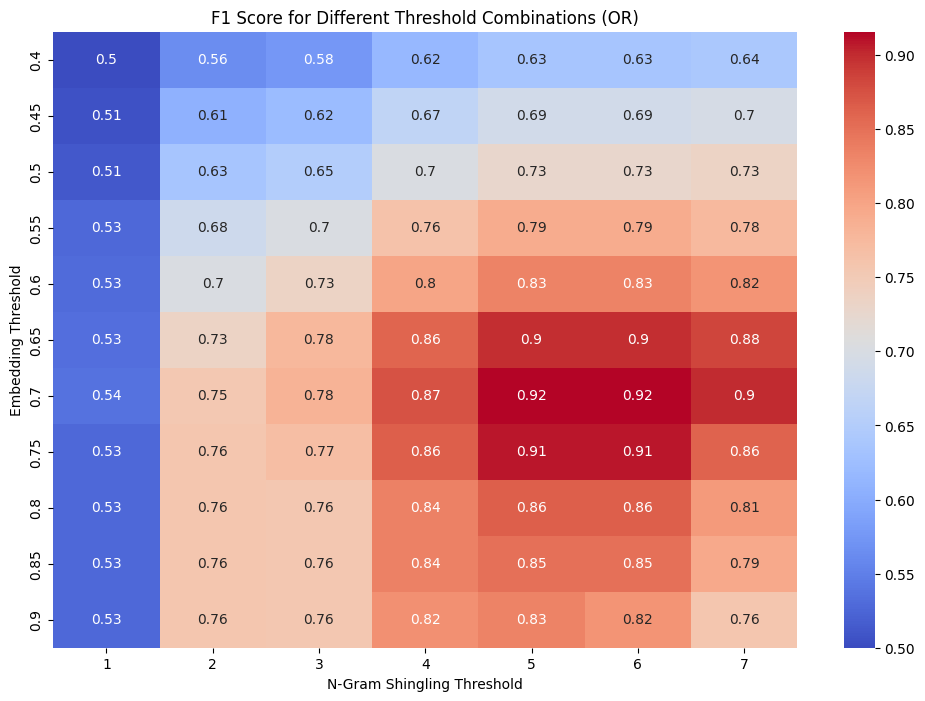

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_matrix = np.array(accuracy_scores_or).reshape((len(emb_thresholds), len(ngm_thresholds)))
f1_matrix = np.array(f1_scores_or).reshape((len(emb_thresholds), len(ngm_thresholds)))

plt.figure(figsize=(12, 8))
ax = sns.heatmap(accuracy_matrix, annot=True, cmap='coolwarm')
plt.xlabel('N-Gram Shingling Threshold')
plt.ylabel('Embedding Threshold')
ax.set_yticklabels(emb_thresholds)
ax.set_xticklabels(ngm_thresholds)
plt.title('Accuracy for Different Threshold Combinations (OR)')
plt.show()

plt.figure(figsize=(12, 8))
ax = sns.heatmap(f1_matrix, annot=True, cmap='coolwarm')
plt.xlabel('N-Gram Shingling Threshold')
plt.ylabel('Embedding Threshold')
ax.set_yticklabels(emb_thresholds)
ax.set_xticklabels(ngm_thresholds)
plt.title('F1 Score for Different Threshold Combinations (OR)')
plt.show()

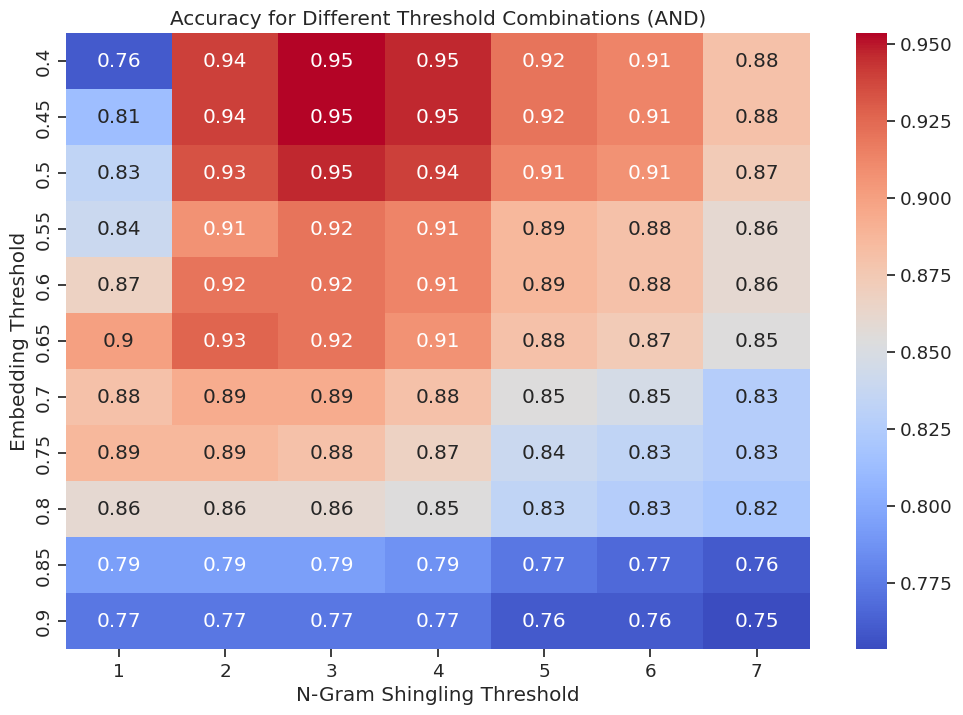

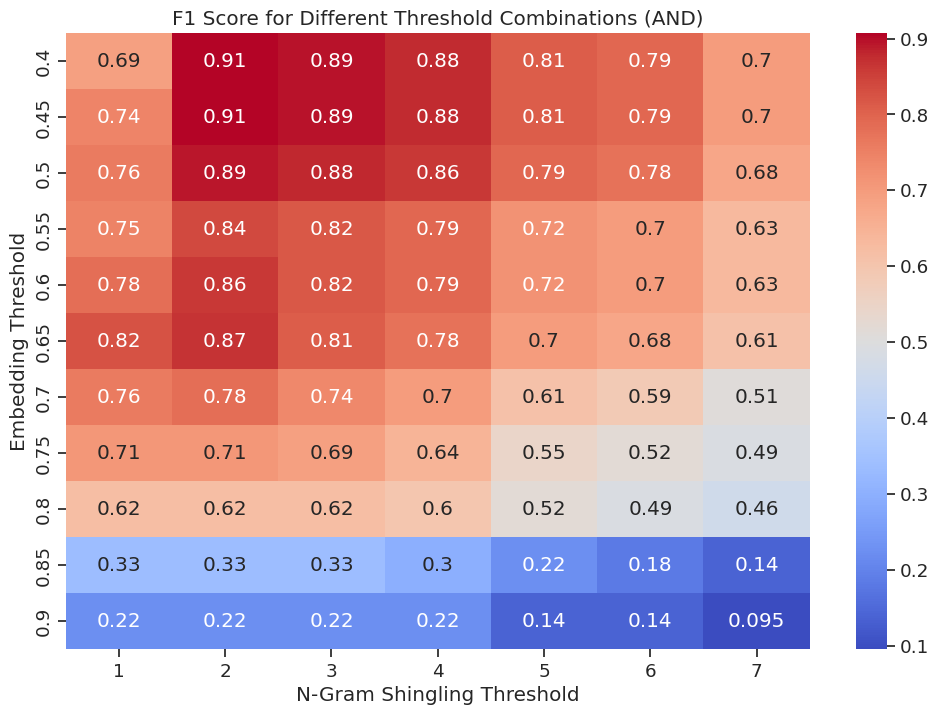

In [137]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_matrix = np.array(accuracy_scores_and).reshape((len(emb_thresholds), len(ngm_thresholds)))
f1_matrix = np.array(f1_scores_and).reshape((len(emb_thresholds), len(ngm_thresholds)))

plt.figure(figsize=(12, 8))
ax = sns.heatmap(accuracy_matrix, annot=True, cmap='coolwarm')
plt.xlabel('N-Gram Shingling Threshold')
plt.ylabel('Embedding Threshold')
ax.set_yticklabels(emb_thresholds)
ax.set_xticklabels(ngm_thresholds)
plt.title('Accuracy for Different Threshold Combinations (AND)')
plt.show()

plt.figure(figsize=(12, 8))
ax = sns.heatmap(f1_matrix, annot=True, cmap='coolwarm')
plt.xlabel('N-Gram Shingling Threshold')
plt.ylabel('Embedding Threshold')
ax.set_yticklabels(emb_thresholds)
ax.set_xticklabels(ngm_thresholds)
plt.title('F1 Score for Different Threshold Combinations (AND)')
plt.show()

In [55]:
import pandas as pd

#responses = pd.read_csv('/home/laviniad/projects/religion_in_congress/src/references/llm-measure-main/logs/reference_experiments/20240907-20-37_Meta-Llama-3-8B-Instruct_0.0_decode/responses.csv')
#responses = pd.read_csv('/home/laviniad/projects/religion_in_congress/src/references/llm-measure-main/logs/reference_experiments/20240909-15-51_Meta-Llama-3-8B-Instruct_0.0_decode/responses.csv')
#responses = pd.read_csv('/home/laviniad/projects/religion_in_congress/src/references/llm-measure-main/logs/reference_experiments/20240909-16-01_Meta-Llama-3-8B-Instruct_0.0_decode/responses.csv')

annotation_df = pd.read_csv('/home/laviniad/projects/religion_in_congress/data/dallas_lavinia_combined_annotations.csv')
#responses = "/home/laviniad/projects/religion_in_congress/src/references/llm-measure-main/logs/reference_experiments/20250325-00-07_gpt-4o_0.0_decode/responses.csv"
#responses = pd.read_csv(responses)

responses = pd.read_csv('/home/laviniad/projects/religion_in_congress/src/references/llm-measure-main/logs/reference_experiments/20250325-00-09_gpt-4o_0.0_decode/responses.csv')

# merge with annotation_df
def clean_text(text):
    return text.replace('<|eot_id|>', '')


def extract_label(llm_label_text):
    label = llm_label_text.split('\n')[0]
    return int(label == 'YES')


def extract_verse(llm_label_text):
    verse =  llm_label_text.split('\n')[-1]
    return verse.lower()


responses['text'] = responses['response_0'].apply(clean_text)
responses['llm_label'] = responses['text'].apply(extract_label)
responses['llm_verse'] = responses['text'].apply(extract_verse)

In [56]:
print(responses.head())

   Unnamed: 0    Index  labels response_0                run_0_probs text  \
0           0    20333       1        YES     [-0.16024991869926453]  YES   
1           1   373263       0         NO                      [0.0]   NO   
2           2  1805833       1        YES   [-0.0005542247672565281]  YES   
3           3  2038851       0         NO   [-3.128163257315464e-07]   NO   
4           4  1765839       0         NO  [-1.9361264946837764e-07]   NO   

   llm_label llm_verse  
0          1       yes  
1          0        no  
2          1       yes  
3          0        no  
4          0        no  


In [57]:
annotation_df['congress_idx'] = annotation_df['congress_idx_dallas'].apply(str)

In [58]:
# filter out congress_idx in annotation_df that are not unique
annotation_df = annotation_df.drop_duplicates(subset='congress_idx')

In [59]:
annotation_df['congress_idx'] = annotation_df['congress_idx_dallas'].astype(str)

In [60]:
# merge with annotation_df

# drop other columns
#responses.drop(columns=['response_0', 'run_0_probs'], inplace=True)
responses['congress_idx'] = responses['Index'].astype(str)

# merge with annotation_df
annotation_df = pd.merge(responses, annotation_df, on='congress_idx')

In [ ]:
# calculate accuracy and f1 score for llm_label and Match_dallas
print(accuracy_score(annotation_df['Match_dallas'], annotation_df['llm_label']))
print(f1_score(annotation_df['Match_dallas'], annotation_df['llm_label']))

0.9530201342281879
0.9041095890410958


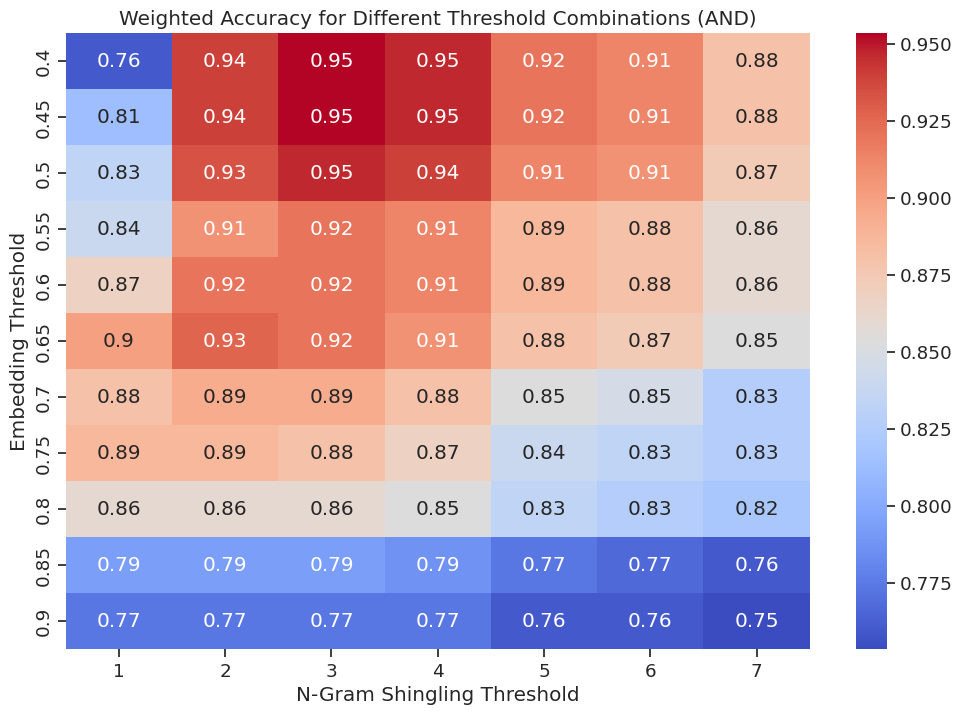

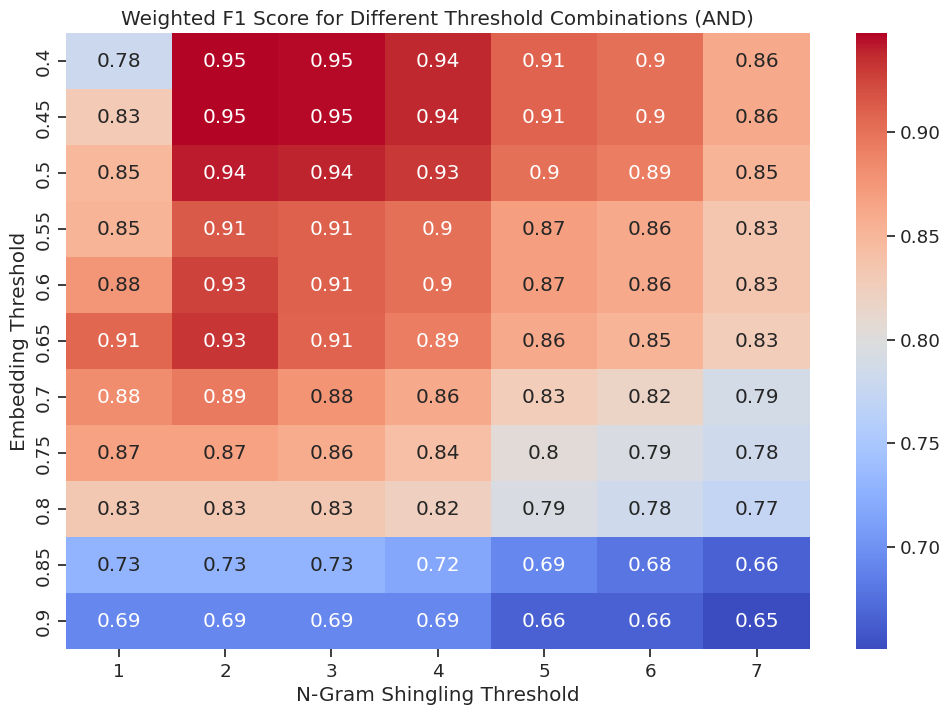

In [150]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_matrix = np.array(weighted_accuracy_scores_and).reshape((len(emb_thresholds), len(ngm_thresholds)))
f1_matrix = np.array(weighted_f1_scores_and).reshape((len(emb_thresholds), len(ngm_thresholds)))

plt.figure(figsize=(12, 8))
ax = sns.heatmap(accuracy_matrix, annot=True, cmap='coolwarm')
plt.xlabel('N-Gram Shingling Threshold')
plt.ylabel('Embedding Threshold')
ax.set_yticklabels(emb_thresholds)
ax.set_xticklabels(ngm_thresholds)
plt.title('Weighted Accuracy for Different Threshold Combinations (AND)')
plt.show()

plt.figure(figsize=(12, 8))
ax = sns.heatmap(f1_matrix, annot=True, cmap='coolwarm')
plt.xlabel('N-Gram Shingling Threshold')
plt.ylabel('Embedding Threshold')
ax.set_yticklabels(emb_thresholds)
ax.set_xticklabels(ngm_thresholds)
plt.title('Weighted F1 Score for Different Threshold Combinations (AND)')
plt.show()

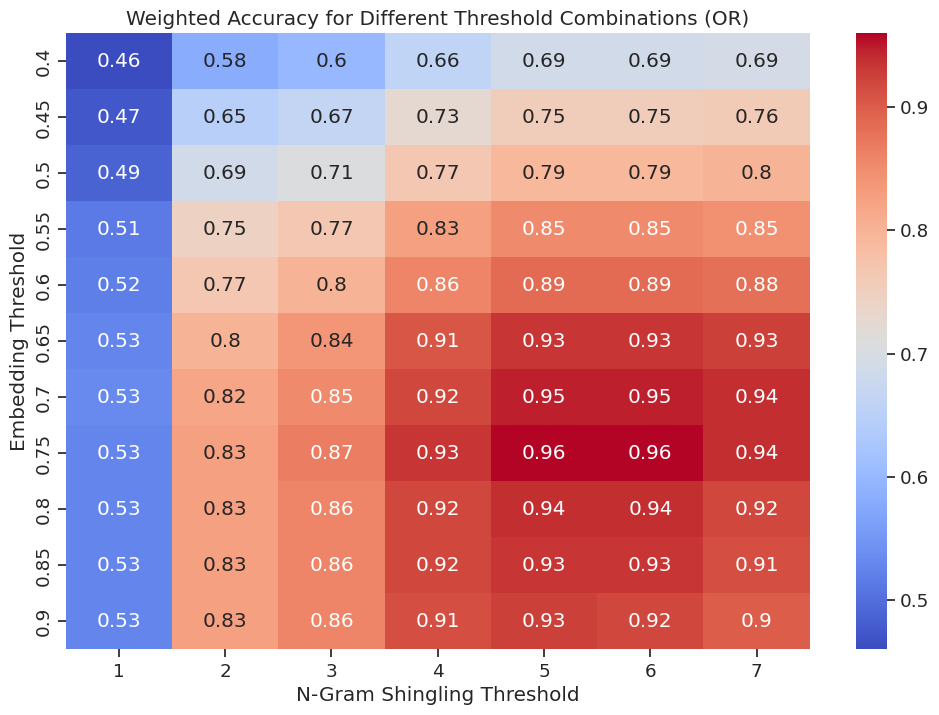

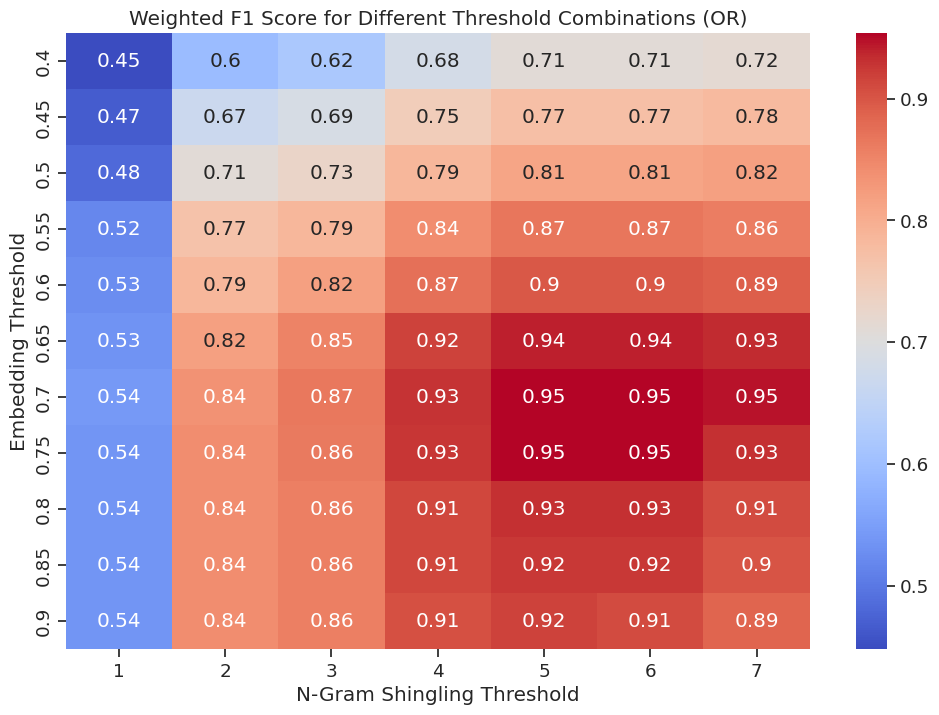

In [151]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_matrix = np.array(weighted_accuracy_scores_or).reshape((len(emb_thresholds), len(ngm_thresholds)))
f1_matrix = np.array(weighted_f1_scores_or).reshape((len(emb_thresholds), len(ngm_thresholds)))

plt.figure(figsize=(12, 8))
ax = sns.heatmap(accuracy_matrix, annot=True, cmap='coolwarm')
plt.xlabel('N-Gram Shingling Threshold')
plt.ylabel('Embedding Threshold')
ax.set_yticklabels(emb_thresholds)
ax.set_xticklabels(ngm_thresholds)
plt.title('Weighted Accuracy for Different Threshold Combinations (OR)')
plt.show()

plt.figure(figsize=(12, 8))
ax = sns.heatmap(f1_matrix, annot=True, cmap='coolwarm')
plt.xlabel('N-Gram Shingling Threshold')
plt.ylabel('Embedding Threshold')
ax.set_yticklabels(emb_thresholds)
ax.set_xticklabels(ngm_thresholds)
plt.title('Weighted F1 Score for Different Threshold Combinations (OR)')
plt.show()

In [2]:
import pandas as pd


path_1 = "/home/laviniad/projects/religion_in_congress/src/references/llm-measure-main/logs/reference_experiments/20250325-00-07_gpt-4o_0.0_decode/responses.csv"
path_2 = "/home/laviniad/projects/religion_in_congress/src/references/llm-measure-main/logs/reference_experiments/20250325-00-09_gpt-4o_0.0_decode/responses.csv"

detect_and_id = pd.read_csv(path_1)
just_detect = pd.read_csv(path_2)

In [4]:
# merge with annotation_df
def clean_text(text):
    return text.replace('<|eot_id|>', '')


def extract_label(llm_label_text):
    label = llm_label_text.split(', ')[0]
    return int(label == 'VERSE')


def extract_verse(llm_label_text):
    verse =  llm_label_text.split(', ')[-1]
    return verse.lower()


detect_and_id['text'] = detect_and_id['response_0'].apply(clean_text)
detect_and_id['llm_label'] = detect_and_id['text'].apply(extract_label)
detect_and_id['llm_verse'] = detect_and_id['text'].apply(extract_verse)